In [1]:
import tensorflow as tf
from glob import glob
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import skimage.color as color

In [2]:
# read images and transform to the desired size
def read_img(file, size = (128,128)):
    img = tf.keras.preprocessing.image.load_img(file, target_size=size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.array(img, dtype=float)
    return img

In [7]:
colour_paths = ['tmp.png']

X_train = []

for c in colour_paths:
    color_image = read_img(c)
    color_image = color_image.astype('uint8')
    color_image = color.rgb2lab(color_image*1.0/255)
    X_train.append(color_image)

X_train = np.array(X_train)
X_train

array([[[[ 1.61143915e+01, -6.79645135e-04,  1.28829128e-03],
         [ 1.46796420e+01, -6.49281162e-04,  1.23073530e-03],
         [ 1.37137838e+01, -6.28840456e-04,  1.19198922e-03],
         ...,
         [ 2.21604366e+01, -8.07599144e-04,  1.53083261e-03],
         [ 2.17042759e+01, -7.97945298e-04,  1.51253341e-03],
         [ 2.07877771e+01, -7.78549198e-04,  1.47576742e-03]],

        [[ 1.89373220e+01, -7.39387539e-04,  1.40153511e-03],
         [ 1.94021883e+01, -7.49225625e-04,  1.42018355e-03],
         [ 1.80029030e+01, -7.19612189e-04,  1.36405024e-03],
         ...,
         [ 2.53167935e+01, -8.74397938e-04,  1.65745208e-03],
         [ 2.39717232e+01, -8.45931868e-04,  1.60349364e-03],
         [ 2.30687044e+01, -8.26821049e-04,  1.56726841e-03]],

        [[ 1.89373220e+01, -7.39387539e-04,  1.40153511e-03],
         [ 2.39717232e+01, -8.45931868e-04,  1.60349364e-03],
         [ 2.26152381e+01, -8.17224226e-04,  1.54907729e-03],
         ...,
         [ 2.75346925e+0

In [8]:
X_train_bw = X_train[:,:,:,0]
X_train_colour = X_train[:,:,:,1:]
X_train_colour = X_train_colour/128

X_train_bw = X_train_bw.reshape(X_train.shape[0], 128, 128, 1)
X_train_colour = X_train_colour.reshape(X_train.shape[0], 128, 128, 2)

In [9]:
X_train_colour.shape

(1, 128, 128, 2)

In [10]:
num_test = 50 # 3
num_train = X_train_colour.shape[0]-num_test # 7
num_half = 250 # 5

X_test_bw = deepcopy(X_train_bw[:num_test])
X_test_colour = deepcopy(X_train_colour[:num_test])

X_train_bw = X_train_bw[num_test:]
X_train_colour = X_train_colour[num_test:]

In [11]:
d_image_shape = (128,128,2)
g_image_shape = (128,128,1)

In [12]:
# Create generator
def make_generator_model():
    model = tf.keras.models.Sequential()

    # encoder
    # (3x3) filter size
    # 64 feature maps
    model.add(tf.keras.layers.Conv2D(64,(3,3),padding='same',strides=2, input_shape=g_image_shape)) #dont need pooling since stride=2 downsizes
    assert model.output_shape == (None, 64, 64, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    #64 x 64 --> size of feature maps
    
    # double the feature maps
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same',strides=2))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    #32 x 32

    #model.add(tf.keras.layers.Conv2D(64, (3,3),padding='same',strides=2))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.LeakyReLU(0.2))
    #16 x 16 

    #model.add(tf.keras.layers.Conv2D(128,(3,3),padding='same',strides=2))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.LeakyReLU(0.2))
    #16 x 16

    # decoder
    # deconvolution layers
    model.add(tf.keras.layers.Conv2DTranspose(64,(3,3), strides=(2,2),padding='same'))

    #32 x 32
    assert model.output_shape == (None, 64, 64, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # 2 output channels --> A and B channels
    model.add(tf.keras.layers.Conv2DTranspose(2,(3,3),strides=(2,2),padding='same'))
    
    #128 x 128
    assert model.output_shape == (None, 128, 128, 2)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Activation('tanh'))
    
    #model.add(tf.keras.layers.Activation('relu'))

    #model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Activation('relu'))
    
    


    #model.add(tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Activation('relu'))

    lchannel = tf.keras.layers.Input(shape=g_image_shape)
    image = model(lchannel)
    return tf.keras.models.Model(lchannel, image)
    #return model

#generator = make_generator_model()
#generated_image = generator(X_train_bw[:num_train], training=False)
#plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
# Create a discriminator in Keras 
# Convolutional Neural Network (CNN)
# Predict whether AB channels are real or fake
def make_discriminator_model():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='same',strides=(2,2),input_shape=d_image_shape))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.20))

    model.add(tf.keras.layers.Conv2D(64,(3,3),padding='same',strides=(2,2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.20))

    model.add(tf.keras.layers.Conv2D(128,(3,3), padding='same', strides=2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.20))     

    # Sigmoid --> predict the image is real or fake
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Activation('sigmoid'))

    image = tf.keras.layers.Input(shape=d_image_shape)
    validity = model(image)
    return tf.keras.models.Model(image, validity)
    #return model

#discriminator = make_discriminator_model()
#decision = discriminator(generated_image)

In [14]:
#Build the Discriminator
discriminator = make_discriminator_model()

generator = make_generator_model()
#gan = define_gan(generator, discriminator)

#def combined_network():  
lchannel = tf.keras.layers.Input(shape=g_image_shape)
image = generator(lchannel) 
valid = discriminator(image)

combined_network = tf.keras.models.Model(lchannel, valid) 
combined_network.compile(loss='binary_crossentropy', 
                        optimizer=tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.5,beta_2=0.999))

In [15]:
gen_losses = []
disc_losses = []
disc_acc = []
gen_acc = []
#n = 100 # 320
y_train_fake = np.zeros([num_half,1]) # 160
y_train_real = np.ones([num_half,1]) # 160
y_gen = np.ones([num_train,1])

#num_epochs=150
#batch_size=32

ValueError: negative dimensions are not allowed

In [16]:
def training(epochs=1, batch_size=128):
    #np.random.shuffle(X_train_L)
    l = X_train_bw[:num_train]
    #np.random.shuffle(X_train_AB)
    ab = X_train_colour[:num_half] # 160

    #generator = generator() 
    #discriminator = discriminator()
    #gan = create_gan(discriminator, generator)

    for epoch in range(1, epochs+1):
        l = X_train_bw[:num_train]
        #np.random.shuffle(X_train_AB)
        ab = X_train_colour[:num_half] # 160
        
        print("Epoch %d" %epoch)

        generated_images = generator.predict(l[:num_half], verbose=1)

        real_images = ab

        X = np.concatenate([real_images, generated_images])
        y = np.concatenate([y_train_real, y_train_fake])

        discriminator.trainable=True
        discriminator.compile(loss='binary_crossentropy', 
                          optimizer=tf.keras.optimizers.Adam(lr=0.00008,beta_1=0.5,beta_2=0.999), 
                          metrics=['accuracy'])
        #discriminator.train_on_batch(X, y)
        d_loss = discriminator.fit(x=X, y= y, validation_split=0.1, batch_size=32,epochs=1,verbose=1)
        disc_losses.append(d_loss.history['loss'][-1])

        discriminator.trainable=False

        discriminator.compile(loss='binary_crossentropy', 
                          optimizer=tf.keras.optimizers.Adam(lr=0.00008,beta_1=0.5,beta_2=0.999), 
                          metrics=['accuracy'])
        
        disc_acc.append(d_loss.history['accuracy'][-1])
        
        combined_network.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.5,beta_2=0.999))
        #combined_network.train_on_batch(l, y_gen)
        g_loss = combined_network.fit(x=l, y=y_gen,validation_split=0.1,batch_size=32,epochs=1,verbose=1)  # validation split 10%
        gen_losses.append(g_loss.history['loss'][-1])
        

        if epoch == 100:
            #print('Reached epoch: ',epoch)

            #print('SHAPE', X_test_L[1].shape)
            #plt.imshow(X_test_L[1])
            test = X_test_bw[1].reshape(1,128,128,1)
            pred = generator.predict(test)
            pred *= 128
            
            cur = np.zeros((128,128,3))
            cur[:,:,0] = test[0][:,:,0]
            cur[:,:,1:] = pred[0]
            xyz = color.lab2xyz(cur)
            rgb = color.xyz2rgb(xyz)
            #img = lab_to_rgb(np.stack((X_test_bw[1],pred_reshaped)))
            plt.imshow(rgb)
            #plt.show()
            #cv2_imshow(pred)
      
    return generator

model_gen1 = training(100, 128)

Epoch 1


AttributeError: 'int' object has no attribute 'assign'

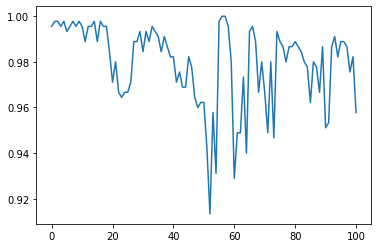

In [21]:
plt.plot(disc_acc)

In [25]:
model_gen1.save('/tf/notebooks/model_mikele_100_ona.h5')

In [19]:
from tensorflow.keras.models import load_model

generator = load_model('generator_100_v5.h5')

In [24]:
colour_paths = ['tmp.png']

X_test_bw = []

for c in colour_paths:
    color_image = read_img(c)
    color_image = color_image.astype('uint8')
    color_image = color.rgb2lab(color_image*1.0/255)
    X_test_bw.append(color_image)

X_test_bw = np.array(X_test_bw)
X_test_bw

array([[[[ 1.61143915e+01, -6.79645135e-04,  1.28829128e-03],
         [ 1.46796420e+01, -6.49281162e-04,  1.23073530e-03],
         [ 1.37137838e+01, -6.28840456e-04,  1.19198922e-03],
         ...,
         [ 2.21604366e+01, -8.07599144e-04,  1.53083261e-03],
         [ 2.17042759e+01, -7.97945298e-04,  1.51253341e-03],
         [ 2.07877771e+01, -7.78549198e-04,  1.47576742e-03]],

        [[ 1.89373220e+01, -7.39387539e-04,  1.40153511e-03],
         [ 1.94021883e+01, -7.49225625e-04,  1.42018355e-03],
         [ 1.80029030e+01, -7.19612189e-04,  1.36405024e-03],
         ...,
         [ 2.53167935e+01, -8.74397938e-04,  1.65745208e-03],
         [ 2.39717232e+01, -8.45931868e-04,  1.60349364e-03],
         [ 2.30687044e+01, -8.26821049e-04,  1.56726841e-03]],

        [[ 1.89373220e+01, -7.39387539e-04,  1.40153511e-03],
         [ 2.39717232e+01, -8.45931868e-04,  1.60349364e-03],
         [ 2.26152381e+01, -8.17224226e-04,  1.54907729e-03],
         ...,
         [ 2.75346925e+0

In [25]:
# prediction

test = X_test_bw[0].reshape(1,128,128,1)
pred = generator.predict(test)
pred *= 128

cur = np.zeros((128,128,3))
cur[:,:,0] = test[0][:,:,0]
cur[:,:,1:] = pred[0]
xyz = color.lab2xyz(cur)
rgb = color.xyz2rgb(xyz)

plt.imshow(rgb)

ValueError: cannot reshape array of size 49152 into shape (1,128,128,1)

In [ ]:
!pip install hyperas
!pip install hyperopt

In [ ]:
from google.colab import drive
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model


def model(x_train, y_train, x_test, y_test):

    model = models.Sequential()
    model.add(layers.Dense({{choice([4, 8, 32])}}, input_shape=(2500,)))
    model.add(layers.Activation({{choice(['relu', 'tanh', 'sigmoid'])}}))
    model.add(layers.Dropout({{uniform(0, 1)}}))
    model.add(layers.Dense({{choice([256, 512, 1024])}}))
    model.add(layers.Activation({{choice(['relu', 'tanh', 'sigmoid'])}}))
    model.add(layers.Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    """if {{choice(['three', 'four'])}} == 'four':
        model.add(layers.Dense(100))
        model.add({{choice([layers.Dropout(0.5), layers.Activation('linear')])}})
        model.add(layers.Activation('relu'))"""

    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
                  metrics=['binary_accuracy'])

    model.fit(x_train, y_train,
              batch_size={{choice([64, 128, 256])}},
              nb_epoch=1,
              verbose=2,
              validation_data=(x_test, y_test))
    score, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}